# **Trilha 6: Deep Learning**
## Assunto: Modelos Sequenciais com *Pytorch*
## Aluno: Willian Pina


In [1]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from IPython.display import display


import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
columns = ['CLASS', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE',
          'ANOREXIA', 'LIVER BIG', 'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS', 
          'ASCITES','VARICES', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', ' PROTOTIPE',
          'HISTOLOGY']
dados = pd.read_csv('hepatitis.data', header=None)
dados.columns=columns

# Tratando os dados
dados.replace('?', np.nan, inplace=True)
dados.dropna(inplace=True)

# Trocando os valores de Class para 0 e 1
dados['CLASS'] = dados['CLASS'].map({1:0,
                                    2:1})

# Tratando os dados que são do tipo Objeto
dados = dados.astype(float)


# Expondo como ficou o tratamento
dados.head()


,CLASS,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTOTIPE,HISTOLOGY
5,1.0,34.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.9,95.0,28.0,4.0,75.0,1.0
10,1.0,39.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.3,78.0,30.0,4.4,85.0,1.0
11,1.0,32.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,59.0,249.0,3.7,54.0,1.0
12,1.0,41.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.9,81.0,60.0,3.9,52.0,1.0
13,1.0,30.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.2,57.0,144.0,4.9,78.0,1.0


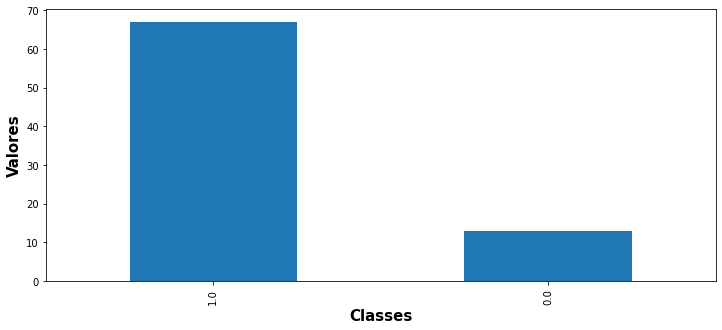

In [3]:
# Verificando o Balanceamento dos Dados do Dataset
plt.figure(figsize=(12,5))
plt.ylabel('Valores', fontsize=15, fontweight='bold')
plt.xlabel('Classes', fontsize=15, fontweight='bold')
dados['CLASS'].value_counts().plot(kind='bar')
plt.show()

In [4]:
# Resolvendo o problema de desbalanceamento
ros = RandomOverSampler(random_state=123)

X_resample, y_resample = ros.fit_resample(dados.drop(labels=['CLASS'], axis=1), dados['CLASS'])

# Concatenando os dados Resampleados com OverSample

dados_resample = pd.concat([X_resample, y_resample], axis=1)

In [5]:
# Verificando o Shape dos dados antigo em relação aos Novos
print(f"Os dados anteriores possuiam {dados.shape[0]} linhas e {dados.shape[1]} colunas.")
print(f"Os dados modificados possuem {dados_resample.shape[0]} linhas e {dados_resample.shape[1]} colunas")

Os dados anteriores possuiam 80 linhas e 20 colunas.
Os dados modificados possuem 134 linhas e 20 colunas


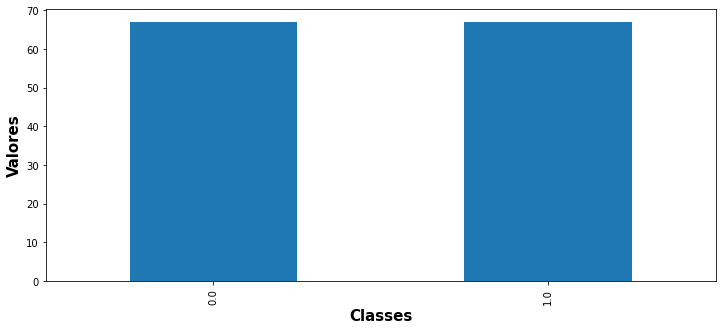

In [6]:
# Verificando o Balanceamento dos Dados do Dataset após modificação
plt.figure(figsize=(12,5))
plt.ylabel('Valores', fontsize=15, fontweight='bold')
plt.xlabel('Classes', fontsize=15, fontweight='bold')
dados_resample['CLASS'].value_counts().plot(kind='bar')
plt.show()

## Modelo DEEP LEARNING - Utilizando o *Pytorch*

### Preparando os dados

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, 
                                                   random_state=123)

### Definindo o Modelo

In [8]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50,50)
        self.layer3 = nn.Linear(50,2)
        
    def forward (self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.softmax(self.layer3(x), dim=1)
        return x
    

### Inicialização

In [9]:
model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.2)
loss_fn = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=19, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=2, bias=True)
)

### Transformando as variáveis

In [10]:
X_train = Variable(torch.from_numpy(X_train.to_numpy())).float()
y_train = Variable(torch.from_numpy(y_train.to_numpy())).long()

X_test = Variable(torch.from_numpy(X_test.to_numpy())).float()
y_test = Variable(torch.from_numpy(y_test.to_numpy())).long()

### Treinamento

In [11]:
import tqdm
EPOCHS = 1000
loss_list =     np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))


for epoch in tqdm.trange(EPOCHS):
    # Forward 
    y_pred = model(X_train)
    
    # Calcular o erro
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Inicializar os Gradientes do Otimizador
    optimizer.zero_grad()
    
    # Recupera Gradientes
    loss.backward()
    
    # Atualiza parametros da rede com base nos gradientes
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        
    

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 829.32it/s]


### Curva de Aprendizado

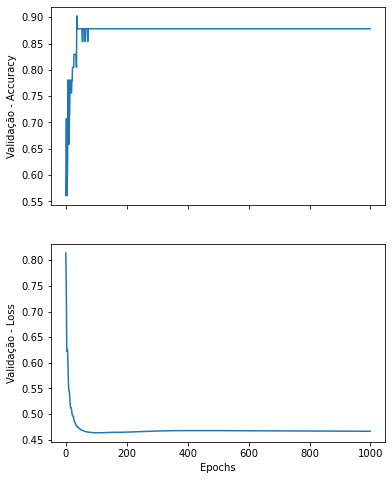

In [12]:
def plot_history(loss_list, accuracy_list):
    fig, (ax1,ax2) = plt.subplots(2, figsize=(6,8), sharex=True)
    
    ax1.plot(accuracy_list)
    ax1.set_ylabel('Validação - Accuracy')
    ax2.plot(loss_list)
    
    ax2.set_ylabel('Validação - Loss')
    ax2.set_xlabel('Epochs')
    
    return

plot_history(loss_list, accuracy_list)

### Avaliando o Modelo

In [13]:
def print_results(y_test, y_pred):
    mc = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Atual: Não',
                                                             'Atual: Sim'],
                     columns=['Predição: Não', 'Predição: Sim'])
    display(mc)
    class_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).transpose()
    display(class_report)
    print(f'Acuracidade: {round(accuracy_score(y_test,y_pred)*100,2)} %')
    return



In [14]:
# Realizando a Predição
y_pred = model(X_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)

In [15]:
# Imprimindo os Resultados
print_results(y_test,y_pred)

,Predição: Não,Predição: Sim
Atual: Não,18,0
Atual: Sim,5,18


,precision,recall,f1-score,support
0,0.782609,1.000000,0.878049,18.000000
1,1.000000,0.782609,0.878049,23.000000
accuracy,0.878049,0.878049,0.878049,0.878049
macro avg,0.891304,0.891304,0.878049,41.000000
weighted avg,0.904560,0.878049,0.878049,41.000000


Acuracidade: 87.8 %


### Conclusões

Em relação ao emprego do Pytorch, o resultado foi similar ao modelo empregado com o TensorFlow.Keras.

Juntamente com o **torch.optim**, foi adicionado o hiperparâmetro `weight_decay` que implementa uma penalidade `l2` juntamente ao algoritmo `Adam`.

Anteriomente (sem aplicar a penalidade `l2`), o modelo apresentava uma acuracidade de 95,7%, ou seja, apresentava características de *overfitting*.

Outro aspecto importante foi a testagem de outros algoritmos constantes da documentação. Os algoritmos `SGD`, `RAdam`, `AdamW` não apresentaram o desempenho adequado para uma acuracidade acima de 80%. Neste contexto, foi escolhido o algoritmo `Adam`.

**Local no GitHub**: 

